In [52]:
import datasets
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoModel, AutoTokenizer
from torch import Tensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, dataset
from torch.utils.data import Dataset as TorchDataset
from torch.nn import TripletMarginWithDistanceLoss
from torch.optim import AdamW
from tqdm import trange
from sklearn.metrics import f1_score
from tqdm.auto import tqdm

In [ ]:
#from src.model import CustomModel сделать классы отдельными файлами

In [2]:
torch.autograd.set_detect_anomaly(True)

In [34]:
class CustomModel(nn.Module):
    def __init__(self, model_name: str, num_entities: int, device: torch.device = None):
        """
        Инициализация модели 
        
        Аргументы:
        - model_name (str): Название предобученной модели.
        - num_entities (int): Количество сущностей для классификатора NER.
        - device (torch.device, optional): Устройство для выполнения вычислений (CPU или GPU). Если не указано, используется CUDA, если доступно.
        """
        super(CustomModel, self).__init__()
        self.device = device if device else torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.ner_classifier = nn.Linear(384, num_entities, device=self.device)
        self.ner_classifier.to(self.device)
        self.model.to(self.device)

    def forward(self, data, mean_pooling: bool = True, tokenized: bool = True) -> Tensor:
        """
        Прямой проход (forward pass) через модель.
        
        Аргументы:
        - data (dict или list): Входные данные. Может быть в виде словаря с input_ids и attention_mask или в виде списка строк (текстов).
        - mean_pooling (bool, optional): Флаг для использования среднего пуллинга. По умолчанию True.
        - tokenized (bool, optional): Флаг, указывающий, токенизированны ли данные. По умолчанию True.

        Возвращает:
        - Tensor: Эмбеддинги токенов после (возможно) среднего пуллинга.
        """
        if not tokenized:
            data = self.tokenizer(data, padding=True, truncation=True, return_tensors='pt')
            data['input_ids'] = data['input_ids'].to(self.device)
            data['attention_mask'] = data['attention_mask'].to(self.device)

        outputs = self.model(data['input_ids'], data['attention_mask'])
        token_embeddings = outputs.last_hidden_state.to(self.device)
        
        if mean_pooling:
            token_embeddings = self.average_pool(token_embeddings, data['attention_mask'])
        
        return token_embeddings

    def average_pool(self, last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        """
        Средний пуллинг эмбеддингов токенов для получения одного эмбеддинга текста.
        
        Аргументы:
        - last_hidden_states (Tensor): Эмбеддинги токенов от модели.
        - attention_mask (Tensor): Маска внимания для токенов.

        Возвращает:
        - Tensor: Эмбеддинг текста после среднего пуллинга.
        """
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [3]:
# Класс для датасета Similarity
class SimilarityDataset(TorchDataset):
    def __init__(self,anchors,positives,negatives):
        self.anchors = anchors
        self.positives = positives
        self.negatives = negatives

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self,idx):
        return self.anchors[idx], self.positives[idx], self.negatives[idx]

In [4]:
# Класс для датасета NER
class NerDataset(TorchDataset):
    def __init__(self, input_ids, attention, labels):
        self.input_ids = input_ids
        self.labels = labels
        self.attention = attention

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention[idx], self.labels[idx]

In [5]:
def translate_labels(tokens, labels, tokenizer):
    """
    Функция для преобразования лейблов в соответствии с токенизированным текстом.

    Аргументы:
    - tokens (list of str): Список исходных токенов (слов).
    - labels (list of int): Список лейблов, соответствующих этим токенам.
    - tokenizer (PreTrainedTokenizer): Токенизатор из библиотеки transformers для токенизации текста.

    Возвращает:
    - new_tokens (list of str): Новый список токенов, полученных после токенизации.
    - new_ids (list of int): Список идентификаторов токенов после токенизации.
    - new_labels (list of int): Новый список лейблов для токенов после преобразования.
    - att_mask (list of int): Маска внимания для токенов.

    Шаги выполнения:
    1. Объединяем исходные токены в одну строку.
    2. Токенизируем полученную строку с использованием токенизатора.
    3. Инициализируем новый список лейблов.
    4. Проходим по токенизированным данным и соотносим их с исходными токенами и их лейблами.
    5. Игнорируем специальные токены [CLS] и [SEP], добавляя для них значение -100 в список лейблов.
    6. Если позиции токенов совпадают с исходными, сохраняем текущий лейбл.
    7. Если токены выходят за пределы текущих позиций, переходим к следующему токену и его лейблу.
    8. Возвращаем новый список токенов, идентификаторы токенов, новые лейблы и маску внимания.
    """
    
    # Объединяем токены в одно предложение
    text = " ".join(tokens)
    max_length = 128
    
    # Токенизируем текст и получаем смещения токенов
    tokenized_inputs = tokenizer(text, padding='max_length', max_length=max_length, return_offsets_mapping=True, is_split_into_words=False)
    new_tokens = tokenized_inputs.tokens()
    new_ids = tokenized_inputs['input_ids']
    att_mask = tokenized_inputs['attention_mask']
    offsets = tokenized_inputs['offset_mapping']

    # Инициализируем новые лейблы
    new_labels = []

    # Инициализируем текущие индексы, лейблы и токены
    current_token_idx = 0
    current_label = labels[current_token_idx]
    current_token = tokens[current_token_idx]
    current_token_start = 0
    current_token_end = len(current_token)

    for i, (token, offset) in enumerate(zip(new_tokens, offsets)):
        # Игнорируем специальные токены [CLS] и [SEP]
        if token in tokenizer.all_special_tokens:
            new_labels.append(-100)
            continue

        # Если токен в пределах текущего исходного токена, добавляем текущий лейбл
        if offset[0] >= current_token_start and offset[1] <= current_token_end:
            new_labels.append(current_label)
        else:
            # Переходим к следующему токену и обновляем текущий лейбл и позиции
            current_token_idx += 1
            if current_token_idx < len(tokens):
                current_label = labels[current_token_idx]
                current_token = tokens[current_token_idx]
                current_token_start = text.index(current_token, current_token_end)
                current_token_end = current_token_start + len(current_token)
            new_labels.append(current_label)

    return new_tokens, new_ids, new_labels, att_mask


In [6]:
def construct_dataset(data_dist, data_para):
    """
    Функция для получения датасета с использованием триплетов (anchor-positive-negative).

    Принимает два списка: 
    - data_dist: список с отрицательными образцами.
    - data_para: список с якорными и позитивными образцами.

    Возвращает список триплетов (anchor, positive, negative), причем:
    - anchor и positive берутся из data_para.
    - negative берется из data_dist.
    
    Если data_dist пуст, то negative берется из временного списка temp.

    Аргументы:
    - data_dist (list of lists): Список, содержащий списки отрицательных образцов.
    - data_para (list of lists): Список, содержащий списки якорных и позитивных образцов.

    Возвращает:
    - list: Новый датасет, состоящий из триплетов (anchor, positive, negative).
    """
    my_new_dataset = []
    temp = []

    for dist, para in zip(data_dist, data_para):
        if len(dist) == 0 and len(temp) == 0:
            continue
        elif len(dist) == 0 and len(temp) != 0:
            my_new_dataset.append([para[0], para[1], temp.pop()])
            continue

        my_new_dataset.append([para[0], para[1], dist[0]])

        if len(para) > 2:
            temp.append(para[2])
        elif len(dist) > 1:
            for item in dist[1:]:
                temp.append(item)
    
    return my_new_dataset

In [7]:
def onehot_with_ignore_label(labels, num_class, ignore_label):
    """
    Функция для one-hot кодирования с игнорированием заданного класса.

    Аргументы:
    labels (Tensor): тензор меток размера (N, M)
    num_class (int): количество классов
    ignore_label (int): метка класса, которую нужно игнорировать

    Возвращает:
    Tensor: one-hot кодированный тензор размера (N, M, C)
    """
    # Создаем копию меток и заменяем игнорируемые метки на числовое значение одного из классов
    dummy_label = num_class
    modified_labels = labels.clone()
    modified_labels[labels == ignore_label] = dummy_label

    # Выполняем one-hot кодирование с дополнительным dummy классом
    one_hot_labels = torch.nn.functional.one_hot(modified_labels, num_classes=num_class + 1)

    # Удаляем dummy класс из кодировки
    one_hot_labels = one_hot_labels[:, :, :-1]

    return one_hot_labels

In [12]:
def prep_ner(ner_data_list):
    """
    Преобразование списка троек в четыре отдельных списка.
    
    Аргументы:
    - ner_data_list (list of tuples): Список троек. Каждая тройка должна содержать:
        - tokens (list of str): Список токенов.
        - input_ids (list of int): Список ID токенов.
        - labels (list of int): Список меток для каждого токена.
        - attention_mask (list of int): Список масок внимания для каждого токена.
        
    Возвращает:
    - tokens_data (list of list of str): Список списков токенов.
    - input_ids_data (list of list of int): Список списков ID токенов.
    - labels_data (list of list of int): Список списков меток для каждого токена.
    - attention_data (list of list of int): Список списков масок внимания для каждого токена.
    """
    tokens_data = []
    input_ids_data = []
    labels_data = []
    attention_data = []
    
    for item in ner_data_list:
        tokens_data.append(item[0])
        input_ids_data.append(item[1])
        labels_data.append(item[2])
        attention_data.append(item[3])
        
    return tokens_data, input_ids_data, labels_data, attention_data

In [50]:
def set_seed(seed):
    """
    Фиксация случайного seed для всех используемых библиотек.
    
    Аргумент:
    - seed (int): Значение seed для фиксации.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

    # Обеспечение повторяемости результатов на GPU (если на это дело не влияют особенности алгоритма)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [53]:
# Фиксиру seed для дальнейшего обучения
set_seed(42)

In [54]:
# Слабая но, относительно лёгкая модель, на моём железе потянет
model = CustomModel("d0rj/e5-small-en-ru", num_entities = 7)

In [10]:
# Подгружаю датасеты с huggingface
similar = datasets.load_dataset("inkoziev/paraphrases")\
data_ner = datasets.load_dataset("wikiann", 'ru')

In [46]:
# Подготавливаю данные для обучения на NER
ner_data_list = []
for i in trange(3000):
    ner_data_list.append(translate_labels(data_ner['train']['tokens'][i],
                            data_ner['train']['ner_tags'][i],
                            model.tokenizer))  

100%|██████████| 3000/3000 [06:59<00:00,  7.15it/s]


In [90]:
# Сохраняю в пикл
with open('tuples.pkl', 'wb') as f:
    pickle.dump(ner_data_list, f)

In [9]:
# Беру с пикла
with open('tuples.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [61]:
# Беру из памяти
tokens_data,input_ids_data, labels_data,attention_data = prep_ner(ner_data_list)

In [15]:
# Беру из пикла (то же самое что и из памяти)
tokens_data,input_ids_data, labels_data,attention_data = prep_ner(loaded_data)

In [17]:
# Делаю промежуточное звено, между датасетом и данными
my_new_dataset = np.array(construct_dataset(similar['train']['distractors'],similar['train']['paraphrases']))

In [18]:
# Датасет для обучения на задачу similarity
train_dataset = SimilarityDataset(my_new_dataset[:2500,0],
                        my_new_dataset[:2500,1],
                        my_new_dataset[:2500,2])

весь код с данными выше нужен, чтобы батчи формировались следующим образом
есть кортежы по n элементов, где i элементу из кортежа acnhors соответствует i элементы из кортежей
positives и negatives таким образом, они образуют тройки anchors-positives-negative

In [19]:
# Датасет для тестирования задачи similarity
test_dataset = SimilarityDataset(my_new_dataset[2500::,0],
                       my_new_dataset[2500::,1],
                       my_new_dataset[2500::,2])

Такой размер обучающей выборки, аргументирован тем, что когдая это пишу, до конца 22 мая осталось ~30 минут
К моему величайшему сожалению, местами мне не хватило по человечески реализовать то, что я задумал, к примеру
подачу данных в модель через DataLoader. В ходе работы я столкнулся с ошибкой, которую не смог преодолеть, а т.к
времени было мало, решил, что надо уже показать хоть что-то :)

In [20]:
# Датасет для обучения на NER
dataset_ner_train = NerDataset(input_ids_data[:2500],attention_data[:2500], labels_data[:2500])

In [21]:
# Датасет для тестирования NER
dataset_ner_test = NerDataset(input_ids_data[2500:],
                               attention_data[2500:],
                               labels_data[2500:])

In [22]:
# Объявляю девайс
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
# Глобальные переменные
atch_size = 16
train_len = 2500
test_len = 500

In [24]:
# Объявляю датафреймы
dataloader_train_ner = DataLoader(dataset_ner_train, batch_size=batch_size,shuffle=True)
dataloader_train_s = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
dataloader_test_ner = DataLoader(dataset_ner_test,batch_size=batch_size,shuffle=True)
dataloader_test_s = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

  0%|          | 0/3 [00:00<?, ?it/s]

Training Processing:   0%|          | 0/156.25 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Processing:   0%|          | 0/31.25 [00:00<?, ?it/s]

Epoch 1/3
Train triplet loss: 0.32411726568914523
Train cross-entropy loss: 0.6653361222736395
Validation triplet loss: 0.31070799520239234
Validation cross-entropy loss: 0.6564768212847412
Validation F1 score: 0.10370464719538687


Training Processing:   0%|          | 0/156.25 [00:00<?, ?it/s]

Evaluation Processing:   0%|          | 0/31.25 [00:00<?, ?it/s]

Epoch 2/3
Train triplet loss: 0.19714573459925167
Train cross-entropy loss: 0.6350270405791367
Validation triplet loss: 0.3214247156865895
Validation cross-entropy loss: 0.6009730942314491
Validation F1 score: 0.08893142645048818


Training Processing:   0%|          | 0/156.25 [00:00<?, ?it/s]

Evaluation Processing:   0%|          | 0/31.25 [00:00<?, ?it/s]

Epoch 3/3
Train triplet loss: 0.1570461200206143
Train cross-entropy loss: 0.5906964374148542
Validation triplet loss: 0.26566224824637175
Validation cross-entropy loss: 0.5725203508045524
Validation F1 score: 0.1303076331179838


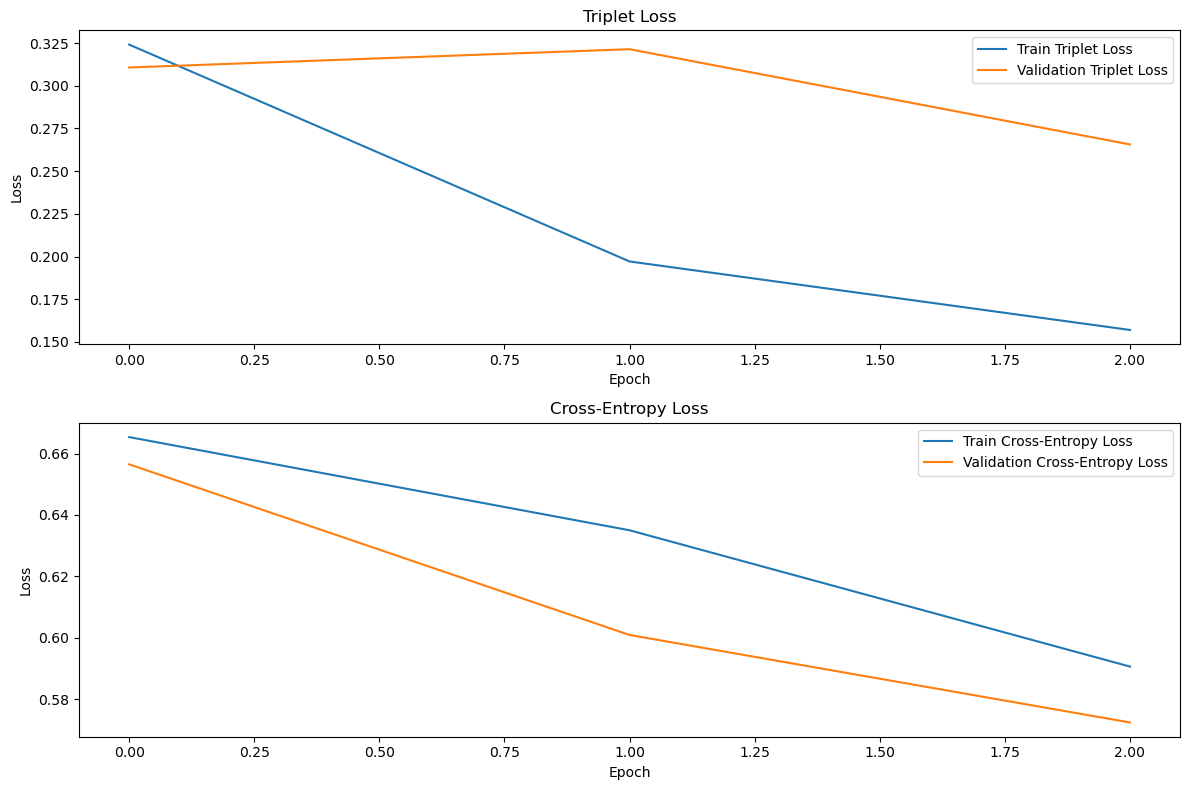

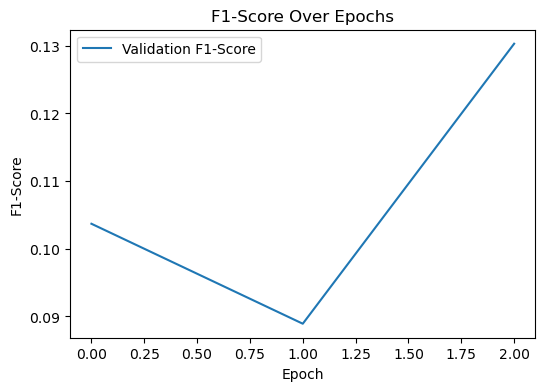

In [55]:
# Основные настройки
optimizer = AdamW(model.model.parameters(), lr=3e-5)
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))
cross_entropy_loss = nn.CrossEntropyLoss()

train_triplet_losses = []
train_cross_losses = []
val_triplet_losses = []
val_cross_losses = []
f1_scores = []

for i in tqdm(range(3), total=3):
    
    # Обучение
    model.train()
    total_triplet_loss = 0
    total_cross_loss = 0
    total_batches = 0
    
    for ner_batch, similarity_batch in tqdm(zip(dataloader_train_ner, dataloader_train_s), total=train_len/batch_size, desc="Training Processing"):
        anchors, positives, negatives = similarity_batch
        input_ids_data, attention_data, labels_data = ner_batch
        
        # Перенос данных на устройство
        ten_ids = torch.stack(input_ids_data).to(device)
        ten_att = torch.stack(attention_data).to(device)
        data = {"input_ids": ten_ids, "attention_mask": ten_att}
        
        # Прямой проход через модель
        anchors = model.forward(anchors, mean_pooling=True, tokenized=False)
        positives = model.forward(positives, mean_pooling=True, tokenized=False)
        negatives = model.forward(negatives, mean_pooling=True, tokenized=False)
        
        # Вычисление тройственного лосса
        loss = triplet_loss(anchors, positives, negatives)
        
        # Обработка данных для NER задачи
        ners = torch.stack(labels_data).to(device)
        pred_tags = model.ner_classifier(model.forward(data, mean_pooling=False, tokenized=True))
        labels = onehot_with_ignore_label(ners.to(torch.int64), 7, -100).to(torch.float).to(device)
        
        # Вычисление кросс-энтропийного лосса
        cross_loss = cross_entropy_loss(pred_tags, labels)
        
        # Обратное распространение ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        cross_loss.backward()
        optimizer.step()
        
        total_triplet_loss += loss.item()
        total_cross_loss += cross_loss.item()
        total_batches += 1

    train_triplet_losses.append(total_triplet_loss / total_batches)
    train_cross_losses.append(total_cross_loss / total_batches)
    
    # Валидация
    model.model.eval()
    total_triplet_loss_eval = 0
    total_cross_loss_eval = 0
    total_batches_eval = 0
    all_preds = []
    all_labels = []

    for ner_batch, similarity_batch in tqdm(zip(dataloader_test_ner, dataloader_test_s), total=test_len/batch_size, desc="Evaluation Processing"):
        with torch.no_grad():
            anchors, positives, negatives = similarity_batch
            input_ids_data, attention_data, labels_data = ner_batch
            
            # Перенос данных на устройство
            ten_ids = torch.stack(input_ids_data).to(device)
            ten_att = torch.stack(attention_data).to(device)
            data = {"input_ids": ten_ids, "attention_mask": ten_att}
            
            # Прямой проход через модель
            anchors = model.forward(anchors, mean_pooling=True, tokenized=False)
            positives = model.forward(positives, mean_pooling=True, tokenized=False)
            negatives = model.forward(negatives, mean_pooling=True, tokenized=False)
            
            # Вычисление тройственного лосса
            loss_val = triplet_loss(anchors, positives, negatives)
            
            # Обработка данных для NER задачи
            ners = torch.stack(labels_data).to(device)
            pred_eval = model.ner_classifier(model.forward(data, mean_pooling=False, tokenized=True))
            labels_eval = onehot_with_ignore_label(ners.to(torch.int64), 7, -100).to(torch.float).to(device)
            
            # Вычисление кросс-энтропийного лосса
            cross_loss_val = cross_entropy_loss(pred_eval, labels_eval)
            
            total_triplet_loss_eval += loss_val.item()
            total_cross_loss_eval += cross_loss_val.item()
            total_batches_eval += 1
            
            preds = torch.argmax(pred_eval, dim=1).cpu().numpy().flatten()
            labels = torch.argmax(labels_eval, dim=1).cpu().numpy().flatten()
            
            all_preds.extend(preds)
            all_labels.extend(labels)

    val_triplet_losses.append(total_triplet_loss_eval / total_batches_eval)
    val_cross_losses.append(total_cross_loss_eval / total_batches_eval)
    f1 = f1_score(all_labels, all_preds, average='macro')
    f1_scores.append(f1)
    
    # Вывод результатов на экран
    print(f"Epoch {i+1}/{3}")
    print(f"Train triplet loss: {train_triplet_losses[-1]}")
    print(f"Train cross-entropy loss: {train_cross_losses[-1]}")
    print(f"Validation triplet loss: {val_triplet_losses[-1]}")
    print(f"Validation cross-entropy loss: {val_cross_losses[-1]}")
    print(f"Validation F1 score: {f1}")

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(val_triplet_losses, label='Validation Triplet Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Triplet Loss')

plt.subplot(2, 1, 2)
plt.plot(train_cross_losses, label='Train Cross-Entropy Loss')
plt.plot(val_cross_losses, label='Validation Cross-Entropy Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss')

plt.tight_layout()
plt.show()

# График F1-Score
plt.figure(figsize=(6, 4))
plt.plot(f1_scores, label='Validation F1-Score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Over Epochs')
plt.show()

В заключении могу сказать, что данная работа вызвала у меня много проблем, а конечный результат не очень обрадовал.
Начну с обучающей выборки для NER: я искал много разных датасетов, но подходящий на русском был только этот. Однако, позже я обнаружил, что он требует дополнительной обработки, а именно, т.к я используею bert-based модель, а она токенизирует слова по кускам, то соответственно нужно переделывать разметку датасета почти с 0. Т.е поставить каждому токену в соответствие его класс.
Допускаю, что итоговый скор связан с тем, что данные оказались слишком плохими для такой задачи.
Если говорить о задаче Similarity, то там наблюдается снижение лосса, что говорит о том, что модель чему-то начинает учиться.

Что можно было сделать лучше:
1. Лучше сделать класс модели(вынести в отдельный модуль, разбить на более мелкией части)
2. Перебрать больше чем 2 модели для обучения(я брал DeepPavlov/rubert-uncased он был ещё хуже)
3. Выбрать лучше датасет, а не тратить время на тот, который я выбрал.